In [1]:
import random
from pathlib import Path

import cv2
import torch
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from src.models import SegmentationModel, ConvNet
from src.dataset import get_transforms
from src.visualization import show_example
from src.show_offsets import show_dconv_offset, show_dconv_offset_v2


dataset_path = Path("dataset/ADEChallengeData2016")

# Load models checkpoints

In [2]:
models = {
    'conv': {
        "ckpt": "models/resnet50-conv/last.ckpt",
        "use_deform_convs": None,
    },
    'def-conv-v1': {
        "ckpt": "models/resnet50-def-conv-v1/last.ckpt",
        "use_deform_convs": "v1",
    },
    'def-conv-v2': {
        "ckpt": "models/resnet50-def-conv-v2/last.ckpt",
        "use_deform_convs": "v2",
    }
}

for model_name in tqdm(models):
    model = SegmentationModel.load_from_checkpoint(
        models[model_name]["ckpt"],
        model=ConvNet(num_class=150, dropout=0.1, use_deform_convs=models[model_name]["use_deform_convs"]),
        loss_func=None,
        map_location='cpu',
    )
    # disable randomness, dropout, etc...
    model.eval();
    models[model_name] = model


transforms = get_transforms(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

  0%|          | 0/3 [00:00<?, ?it/s]

# Visualize predictions

In [3]:
image_paths = list(sorted((dataset_path / f"images/validation").iterdir()))
annotation_paths = list(sorted((dataset_path / f"annotations/validation").iterdir()))

  0%|          | 0/6 [00:00<?, ?it/s]

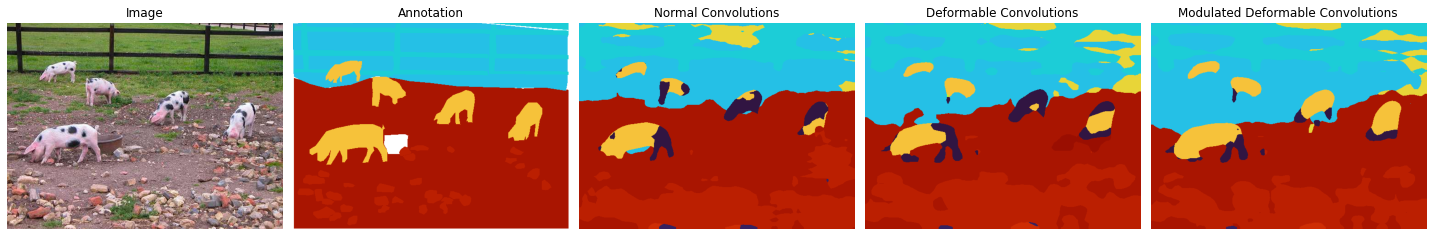

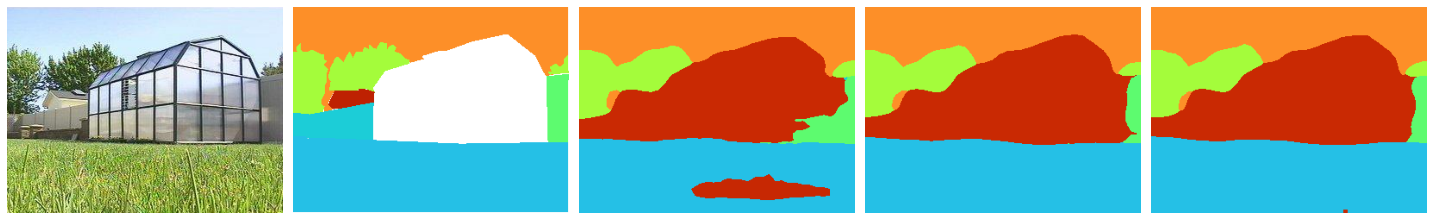

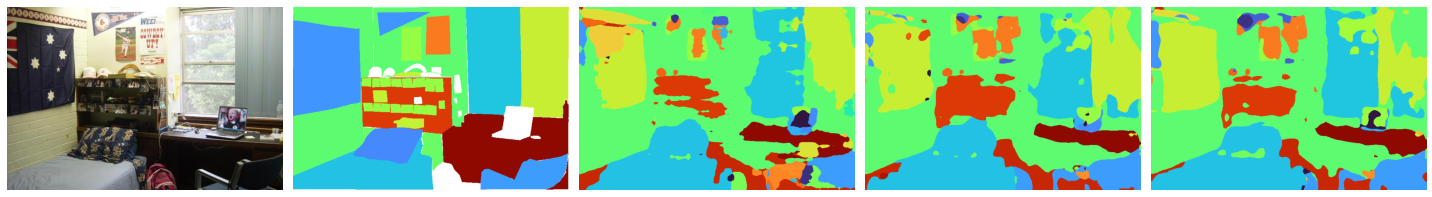

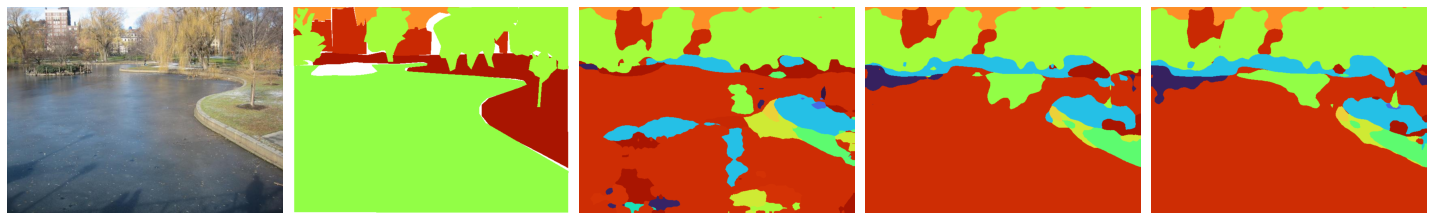

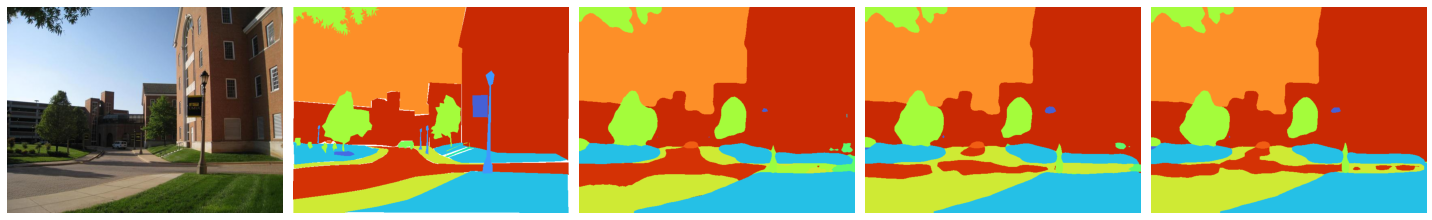

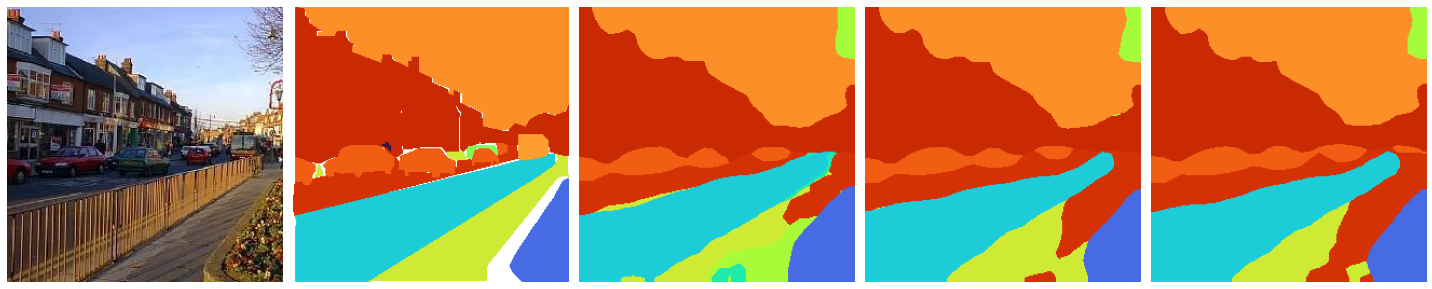

In [4]:
image_indexes = [611, 392, 1330, 692, 570, 866]
# image_indexes = [None] * 5  # for random images

is_first_row = True
for index in tqdm(image_indexes):
    index = index or random.choice(list(range(2000)))
    image_path = image_paths[index]
    annotation_path = annotation_paths[index]

    image = cv2.imread(str(image_path))[:,:,::-1]
    annotation = cv2.imread(str(annotation_path))

    transformed = transforms(image=image, mask=annotation)

    predictions = []
    for _, model in models.items():
        output = model(transformed['image'].unsqueeze(0))[0]
        prediction = output.argmax(0).unsqueeze(-1) + 1

        # # The model classifies each pixel, if we don’t need it, then we can use the threshold and return only confident predictions.
        # threshold = 0.8
        # # Apply softmax to the logits to obtain the predicted probabilities for each pixel
        # probs = torch.nn.functional.softmax(output, dim=0)
        # # Apply the threshold to the probabilities to make a binary decision
        # binary_decision = (probs.max(dim=0).values < threshold)
        # prediction[binary_decision] = 0

        predictions.append(prediction)

    titles = None
    if is_first_row:
        titles = ["Image", "Annotation", "Normal Convolutions", "Deformable Convolutions", "Modulated Deformable Convolutions"]
    show_example(image, annotation, predictions=predictions, titles=titles)
    is_first_row = False

# Deformable convolutions offset visualization

In [4]:
image = cv2.imread(str(random.choice(image_paths)))[:,:,::-1]

transforms = get_transforms(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    fixed_img_size=256,
)

transformed = transforms(image=image)
image = transformed['image'].permute(1, 2, 0)
if image.min() < 0:
    image -= image.min()
    image /= image.max()

In [5]:
# We register several hooks to get intermediate tensors from the network.

tensors = {}


def get_tensors(name):
    def hook(model, input, output):
        tensors[name] = output.detach()
    return hook


models['def-conv-v2'].model.modified_resnet.backbone.layer4[2].conv2.offset_conv.register_forward_hook(get_tensors('layer4_2.conv2.offset'));
models['def-conv-v2'].model.modified_resnet.backbone.layer4[1].conv2.offset_conv.register_forward_hook(get_tensors('layer4_1.conv2.offset'));
models['def-conv-v2'].model.modified_resnet.backbone.layer4[0].conv2.offset_conv.register_forward_hook(get_tensors('layer4_0.conv2.offset'));

In [6]:
# Infer the model, to obtain offsets
models['def-conv-v2'](transformed['image'].unsqueeze(0))
tensors.keys()

dict_keys(['layer4_0.conv2.offset', 'layer4_1.conv2.offset', 'layer4_2.conv2.offset'])

In [7]:
all_offset = [
    tensors['layer4_0.conv2.offset'],
    tensors['layer4_1.conv2.offset'],
    tensors['layer4_2.conv2.offset'],
]

## Visualization from LIT

Most likely, it works somehow not intuitively clear, so the graph is either wrong or not very indicative

In [21]:
show_dconv_offset(
    im=image,
    all_offset=all_offset,
    filter_size=2,
    dilation=4,
    pad=1,
    plot_area=2,
    plot_level=len(all_offset),
    image_name='test-image',
)

<Figure size 432x288 with 0 Axes>

In [27]:
paths = list(Path("visualization/test-image").glob("*.png"))
images = [cv2.imread(str(path))[:,:,::-1] for path in paths]


@widgets.interact(index=widgets.IntSlider(min=0, max=len(images) - 1, step=1, value=0))
def g(index: int):
    print(paths[index])
    img = images[index]
    plt.figure(figsize=(20, 10))
    plt.imshow(img)
    plt.axis("off")

interactive(children=(IntSlider(value=0, description='index', max=255), Output()), _dom_classes=('widget-inter…

## Another approach

Here we visualize all sampled points.

They are looks kinda uniform, which is confusing.

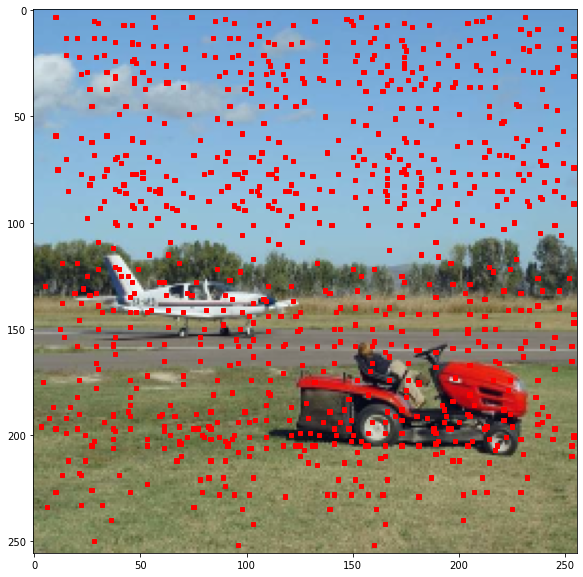

In [8]:
show_dconv_offset_v2(
    im=image,
    all_offset=all_offset,
    filter_size=2,
    dilation=4,
    pad=1,
    plot_area=2,
    plot_level=len(all_offset),
    image_name='test-image',
)